# Projeto Final - Bootcamp CDIA: Sistema de Manutenção Preditiva

## Contextualização
Este projeto desenvolve um sistema inteligente de manutenção preditiva para máquinas industriais, utilizando dados coletados de dispositivos IoT para identificar e prever falhas.

### Objetivos:
- Identificar falhas que possam ocorrer nas máquinas
- Classificar o tipo de falha
- Retornar probabilidades associadas às predições
- Extrair insights operacionais e gerar visualizações

### Tipos de Falhas:
- **FDF**: Falha por Desgaste da Ferramenta
- **FDC**: Falha por Dissipação de Calor
- **FP**: Falha por Potência
- **FTE**: Falha por Tensão Excessiva
- **FA**: Falha Aleatória

## 1. Carregamento e Exploração Inicial dos Dados

In [57]:
# Importar bibliotecas necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.multioutput import MultiOutputClassifier
import xgboost as xgb
from scipy import stats

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Bibliotecas carregadas com sucesso!")

Bibliotecas carregadas com sucesso!


In [58]:
# Carregar os datasets
df_train = pd.read_csv('01_train-Dataset de treino-Avaliação.csv')
df_test = pd.read_csv('02_train-Dataset de avaliação em produção pela API.csv')

print(f"Dataset de treino: {df_train.shape}")
print(f"Dataset de teste: {df_test.shape}")
print("\nPrimeiras 5 linhas do dataset de treino:")
df_train.head()

Dataset de treino: (35260, 15)
Dataset de teste: (7173, 9)

Primeiras 5 linhas do dataset de treino:


,id,id_produto,tipo,temperatura_ar,temperatura_processo,umidade_relativa,velocidade_rotacional,torque,desgaste_da_ferramenta,falha_maquina,FDF (Falha Desgaste Ferramenta),FDC (Falha Dissipacao Calor),FP (Falha Potencia),FTE (Falha Tensao Excessiva),FA (Falha Aleatoria)
0,0,L56434,L,298.3,309.1,90.0,1616.0,31.1,195.0,não,False,False,Não,False,Não
1,1,L48741,L,298.2,308.4,90.0,1388.0,53.8,137.0,Não,False,False,Não,False,Não
2,2,L48850,L,298.2,307.8,90.0,1528.0,31.1,NaN,Não,N,False,Não,False,Não
3,3,M20947,M,300.9,310.8,90.0,1599.0,33.0,7.0,não,False,False,Não,False,não
4,4,L53849,L,-36.0,310.5,90.0,1571.0,33.9,NaN,não,N,False,não,False,Não


In [59]:
# Informações básicas sobre o dataset
print("=== INFORMAÇÕES GERAIS ===")
print(f"Dimensões do dataset de treino: {df_train.shape}")
print(f"Dimensões do dataset de teste: {df_test.shape}")

print("\n=== TIPOS DE DADOS ===")
print(df_train.dtypes)

print("\n=== ESTATÍSTICAS DESCRITIVAS ===")
df_train.describe()

=== INFORMAÇÕES GERAIS ===
Dimensões do dataset de treino: (35260, 15)
Dimensões do dataset de teste: (7173, 9)

=== TIPOS DE DADOS ===
id                                   int64
id_produto                          object
tipo                                object
temperatura_ar                     float64
temperatura_processo               float64
umidade_relativa                   float64
velocidade_rotacional              float64
torque                             float64
desgaste_da_ferramenta             float64
falha_maquina                       object
FDF (Falha Desgaste Ferramenta)     object
FDC (Falha Dissipacao Calor)        object
FP (Falha Potencia)                 object
FTE (Falha Tensao Excessiva)          bool
FA (Falha Aleatoria)                object
dtype: object

=== ESTATÍSTICAS DESCRITIVAS ===


,id,temperatura_ar,temperatura_processo,umidade_relativa,velocidade_rotacional,torque,desgaste_da_ferramenta
count,35260.000000,34644.000000,34661.000000,35260.000000,34509.000000,34637.000000,34308.000000
mean,17629.500000,269.535241,280.457676,89.997672,1380.194181,40.210357,74.373266
std,10178.829582,96.342224,96.943630,0.142191,494.098759,8.831626,110.411937
min,0.000000,-36.000000,-38.000000,80.590429,-161.000000,3.800000,-202.000000
25%,8814.750000,297.900000,308.500000,90.000000,1408.000000,34.300000,28.000000
50%,17629.500000,299.600000,309.800000,90.000000,1483.000000,40.300000,94.000000
75%,26444.250000,301.100000,310.900000,90.000000,1574.000000,46.200000,155.000000
max,35259.000000,304.500000,313.800000,94.575256,2886.000000,76.600000,253.000000


## 2. Análise de Qualidade dos Dados

In [60]:
# Verificar valores ausentes
print("=== VALORES AUSENTES ===")
missing_data = df_train.isnull().sum()
missing_percent = (missing_data / len(df_train)) * 100
missing_df = pd.DataFrame({
    'Coluna': missing_data.index,
    'Valores Ausentes': missing_data.values,
    'Porcentagem': missing_percent.values
})
missing_df = missing_df[missing_df['Valores Ausentes'] > 0].sort_values('Valores Ausentes', ascending=False)
print(missing_df)

=== VALORES AUSENTES ===
                   Coluna  Valores Ausentes  Porcentagem
8  desgaste_da_ferramenta               952     2.699943
6   velocidade_rotacional               751     2.129892
7                  torque               623     1.766875
3          temperatura_ar               616     1.747022
4    temperatura_processo               599     1.698809


In [61]:
# Analisar inconsistências nos dados categóricos
print("=== ANÁLISE DE VALORES CATEGÓRICOS ===")

# Verificar valores únicos em cada coluna categórica
categorical_cols = ['tipo', 'falha_maquina', 'FDF (Falha Desgaste Ferramenta)', 
                   'FDC (Falha Dissipacao Calor)', 'FP (Falha Potencia)', 
                   'FTE (Falha Tensao Excessiva)', 'FA (Falha Aleatoria)']

for col in categorical_cols:
    if col in df_train.columns:
        print(f"\n{col}:")
        print(df_train[col].value_counts())
        print(f"Valores únicos: {df_train[col].unique()}")

=== ANÁLISE DE VALORES CATEGÓRICOS ===

tipo:
tipo
L    23855
M     8799
H     2606
Name: count, dtype: int64
Valores únicos: ['L' 'M' 'H']

falha_maquina:
falha_maquina
Não    21926
não    11303
N        691
0        678
Sim      420
sim      217
y         13
1         12
Name: count, dtype: int64
Valores únicos: ['não' 'Não' 'sim' 'N' '0' 'Sim' 'y' '1']

FDF (Falha Desgaste Ferramenta):
FDF (Falha Desgaste Ferramenta)
False    33729
N          702
0          688
True        70
-           70
1            1
Name: count, dtype: int64
Valores únicos: ['False' 'N' '0' 'True' '-' '1']

FDC (Falha Dissipacao Calor):
FDC (Falha Dissipacao Calor)
False    33649
nao        700
0          686
True       217
y            4
1            4
Name: count, dtype: int64
Valores únicos: ['False' 'nao' '0' 'True' 'y' '1']

FP (Falha Potencia):
FP (Falha Potencia)
Não    22282
não    11462
N        702
0        688
Sim       81
sim       41
1          2
y          2
Name: count, dtype: int64
Valores únic

In [62]:
# Detectar outliers em variáveis numéricas
print("=== DETECÇÃO DE OUTLIERS ===")

numeric_cols = ['temperatura_ar', 'temperatura_processo', 'umidade_relativa', 
               'velocidade_rotacional', 'torque', 'desgaste_da_ferramenta']

outliers_summary = []

for col in numeric_cols:
    if col in df_train.columns:
        # Remover valores não numéricos para análise
        values = pd.to_numeric(df_train[col], errors='coerce')
        Q1 = values.quantile(0.25)
        Q3 = values.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        outliers = values[(values < lower_bound) | (values > upper_bound)]
        outliers_summary.append({
            'Coluna': col,
            'Q1': Q1,
            'Q3': Q3,
            'Lower_Bound': lower_bound,
            'Upper_Bound': upper_bound,
            'Outliers_Count': len(outliers),
            'Min_Value': values.min(),
            'Max_Value': values.max()
        })

outliers_df = pd.DataFrame(outliers_summary)
print(outliers_df)

=== DETECÇÃO DE OUTLIERS ===
                   Coluna      Q1      Q3  Lower_Bound  Upper_Bound  \
0          temperatura_ar   297.9   301.1       293.10       305.90   
1    temperatura_processo   308.5   310.9       304.90       314.50   
2        umidade_relativa    90.0    90.0        90.00        90.00   
3   velocidade_rotacional  1408.0  1574.0      1159.00      1823.00   
4                  torque    34.3    46.2        16.45        64.05   
5  desgaste_da_ferramenta    28.0   155.0      -162.50       345.50   

   Outliers_Count   Min_Value    Max_Value  
0            3132  -36.000000   304.500000  
1            2939  -38.000000   313.800000  
2              35   80.590429    94.575256  
3            4217 -161.000000  2886.000000  
4             291    3.800000    76.600000  
5            3439 -202.000000   253.000000  


## 3. Limpeza e Tratamento dos Dados

In [63]:
# Criar uma cópia para manipulação
df_clean = df_train.copy()

print("=== LIMPEZA DOS DADOS ===")
print(f"Shape inicial: {df_clean.shape}")

# 1. Padronizar valores categóricos
# Falha máquina: converter para binário
df_clean['falha_maquina'] = df_clean['falha_maquina'].str.lower()
df_clean['falha_maquina'] = df_clean['falha_maquina'].map({
    'sim': 1, 'não': 0, 'nao': 0, 'n': 0, 'false': 0, 'true': 1
})

# Padronizar colunas de falhas específicas
failure_columns = ['FDF (Falha Desgaste Ferramenta)', 'FDC (Falha Dissipacao Calor)', 
                  'FP (Falha Potencia)', 'FTE (Falha Tensao Excessiva)', 'FA (Falha Aleatoria)']

for col in failure_columns:
    if col in df_clean.columns:
        df_clean[col] = df_clean[col].astype(str).str.lower()
        df_clean[col] = df_clean[col].map({
            'true': 1, 'false': 0, 'sim': 1, 'não': 0, 'nao': 0, 'n': 0, '0': 0, '1': 1
        })

print("Padronização de valores categóricos concluída.")

=== LIMPEZA DOS DADOS ===
Shape inicial: (35260, 15)
Padronização de valores categóricos concluída.


In [64]:
# 2. Tratar valores numéricos problemáticos
numeric_columns = ['temperatura_ar', 'temperatura_processo', 'umidade_relativa', 
                  'velocidade_rotacional', 'torque', 'desgaste_da_ferramenta']

for col in numeric_columns:
    if col in df_clean.columns:
        # Converter para numérico, substituindo valores inválidos por NaN
        df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')

print("\n=== VALORES APÓS CONVERSÃO NUMÉRICA ===")
print(df_clean[numeric_columns].describe())

# Identificar valores fisicamente impossíveis
print("\n=== VALORES FISICAMENTE IMPOSSÍVEIS ===")
print(f"Temperaturas negativas (ar): {(df_clean['temperatura_ar'] < 0).sum()}")
print(f"Velocidades negativas: {(df_clean['velocidade_rotacional'] < 0).sum()}")
print(f"Desgaste negativo: {(df_clean['desgaste_da_ferramenta'] < 0).sum()}")
print(f"Umidade > 100%: {(df_clean['umidade_relativa'] > 100).sum()}")


=== VALORES APÓS CONVERSÃO NUMÉRICA ===
       temperatura_ar  temperatura_processo  umidade_relativa  \
count    34644.000000          34661.000000      35260.000000   
mean       269.535241            280.457676         89.997672   
std         96.342224             96.943630          0.142191   
min        -36.000000            -38.000000         80.590429   
25%        297.900000            308.500000         90.000000   
50%        299.600000            309.800000         90.000000   
75%        301.100000            310.900000         90.000000   
max        304.500000            313.800000         94.575256   

       velocidade_rotacional        torque  desgaste_da_ferramenta  
count           34509.000000  34637.000000            34308.000000  
mean             1380.194181     40.210357               74.373266  
std               494.098759      8.831626              110.411937  
min              -161.000000      3.800000             -202.000000  
25%              1408.000000

In [65]:
# 3. Tratar outliers e valores impossíveis
# Remover ou corrigir valores fisicamente impossíveis

# Temperaturas muito baixas (provavelmente erro de digitação)
df_clean.loc[df_clean['temperatura_ar'] < 250, 'temperatura_ar'] = np.nan

# Velocidades negativas
df_clean.loc[df_clean['velocidade_rotacional'] < 0, 'velocidade_rotacional'] = np.nan

# Desgaste negativo
df_clean.loc[df_clean['desgaste_da_ferramenta'] < 0, 'desgaste_da_ferramenta'] = np.nan

# Umidade impossível
df_clean.loc[df_clean['umidade_relativa'] > 100, 'umidade_relativa'] = 100

print("Correção de valores impossíveis concluída.")
print(f"Shape após limpeza: {df_clean.shape}")

Correção de valores impossíveis concluída.
Shape após limpeza: (35260, 15)


In [66]:
# 4. Tratar valores ausentes
print("=== TRATAMENTO DE VALORES AUSENTES ===")

# Para variáveis numéricas, usar mediana por tipo de máquina
for col in numeric_columns:
    if col in df_clean.columns and df_clean[col].isnull().sum() > 0:
        # Imputar pela mediana do tipo de máquina
        for machine_type in df_clean['tipo'].unique():
            mask = (df_clean['tipo'] == machine_type) & df_clean[col].isnull()
            median_value = df_clean[df_clean['tipo'] == machine_type][col].median()
            df_clean.loc[mask, col] = median_value

# Verificar valores ausentes após imputação
print("Valores ausentes após imputação:")
print(df_clean.isnull().sum())

# Remover linhas com muitos valores ausentes se necessário
threshold = 0.3  # Remover linhas com mais de 30% de valores ausentes
df_clean = df_clean.dropna(thresh=int(threshold * len(df_clean.columns)))

print(f"\nShape final após limpeza: {df_clean.shape}")

=== TRATAMENTO DE VALORES AUSENTES ===
Valores ausentes após imputação:
id                                   0
id_produto                           0
tipo                                 0
temperatura_ar                       0
temperatura_processo                 0
umidade_relativa                     0
velocidade_rotacional                0
torque                               0
desgaste_da_ferramenta               0
falha_maquina                      703
FDF (Falha Desgaste Ferramenta)     70
FDC (Falha Dissipacao Calor)         4
FP (Falha Potencia)                  2
FTE (Falha Tensao Excessiva)         0
FA (Falha Aleatoria)                70
dtype: int64

Shape final após limpeza: (35260, 15)


## 4. Análise Exploratória e Visualizações

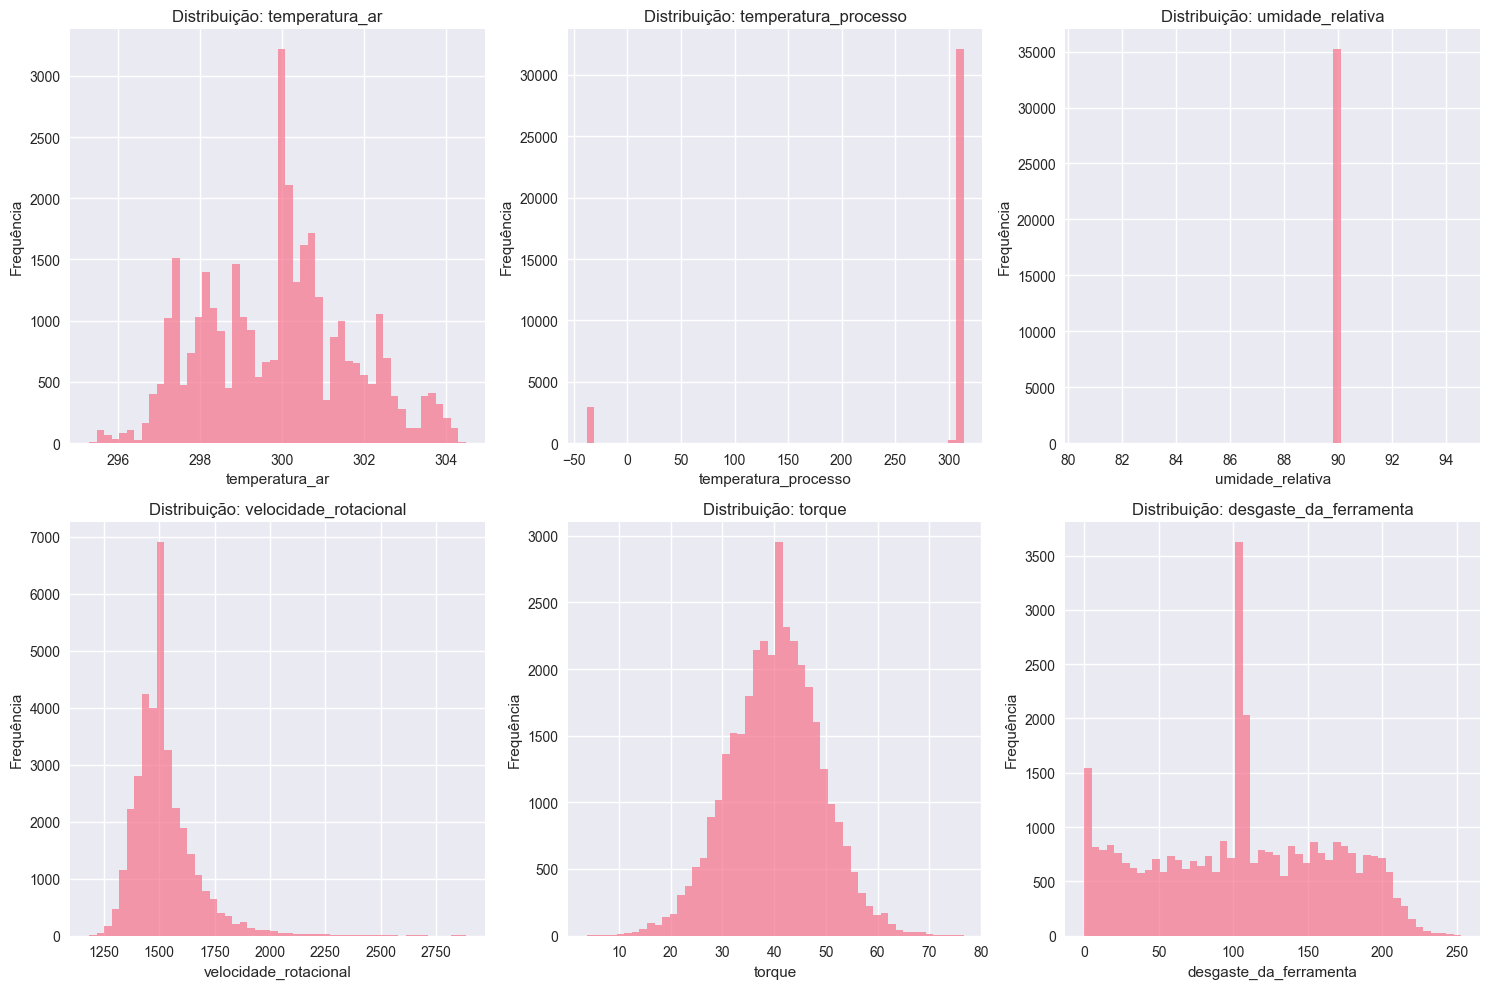

In [67]:
# Distribuição das variáveis numéricas
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, col in enumerate(numeric_columns):
    if col in df_clean.columns:
        df_clean[col].hist(bins=50, ax=axes[i], alpha=0.7)
        axes[i].set_title(f'Distribuição: {col}')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Frequência')

plt.tight_layout()
plt.show()

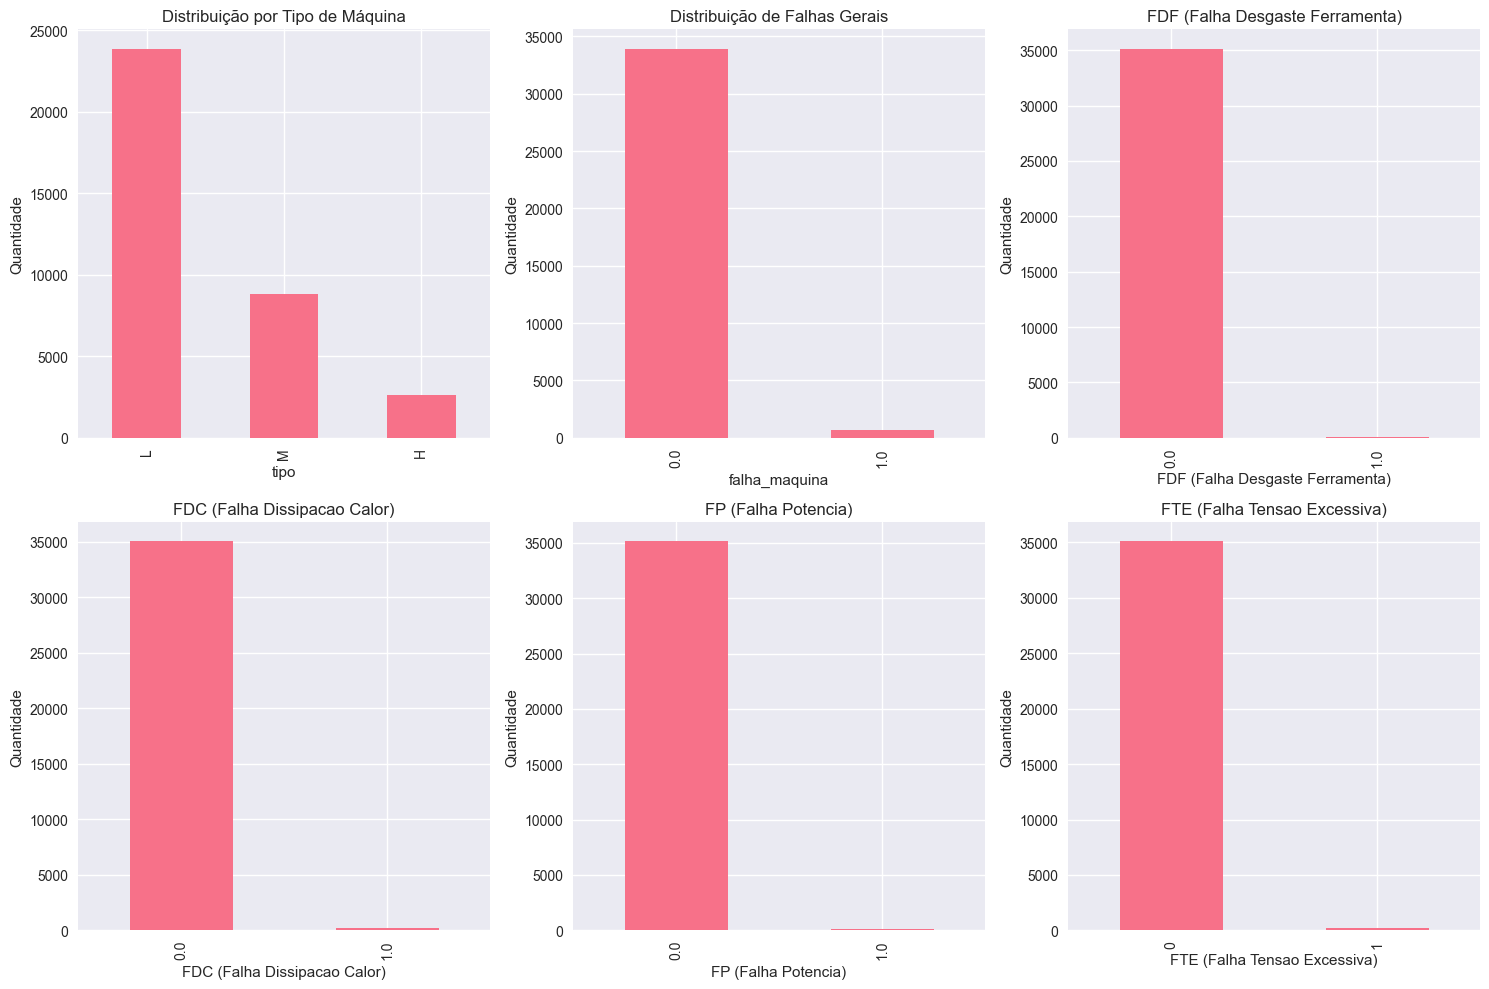

In [68]:
# Análise de falhas por tipo de máquina
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

# Distribuição por tipo de máquina
df_clean['tipo'].value_counts().plot(kind='bar', ax=axes[0])
axes[0].set_title('Distribuição por Tipo de Máquina')
axes[0].set_ylabel('Quantidade')

# Falhas gerais
df_clean['falha_maquina'].value_counts().plot(kind='bar', ax=axes[1])
axes[1].set_title('Distribuição de Falhas Gerais')
axes[1].set_ylabel('Quantidade')

# Falhas específicas
failure_cols = [col for col in failure_columns if col in df_clean.columns]
for i, col in enumerate(failure_cols[:4]):
    df_clean[col].value_counts().plot(kind='bar', ax=axes[i+2])
    axes[i+2].set_title(f'{col}')
    axes[i+2].set_ylabel('Quantidade')

plt.tight_layout()
plt.show()

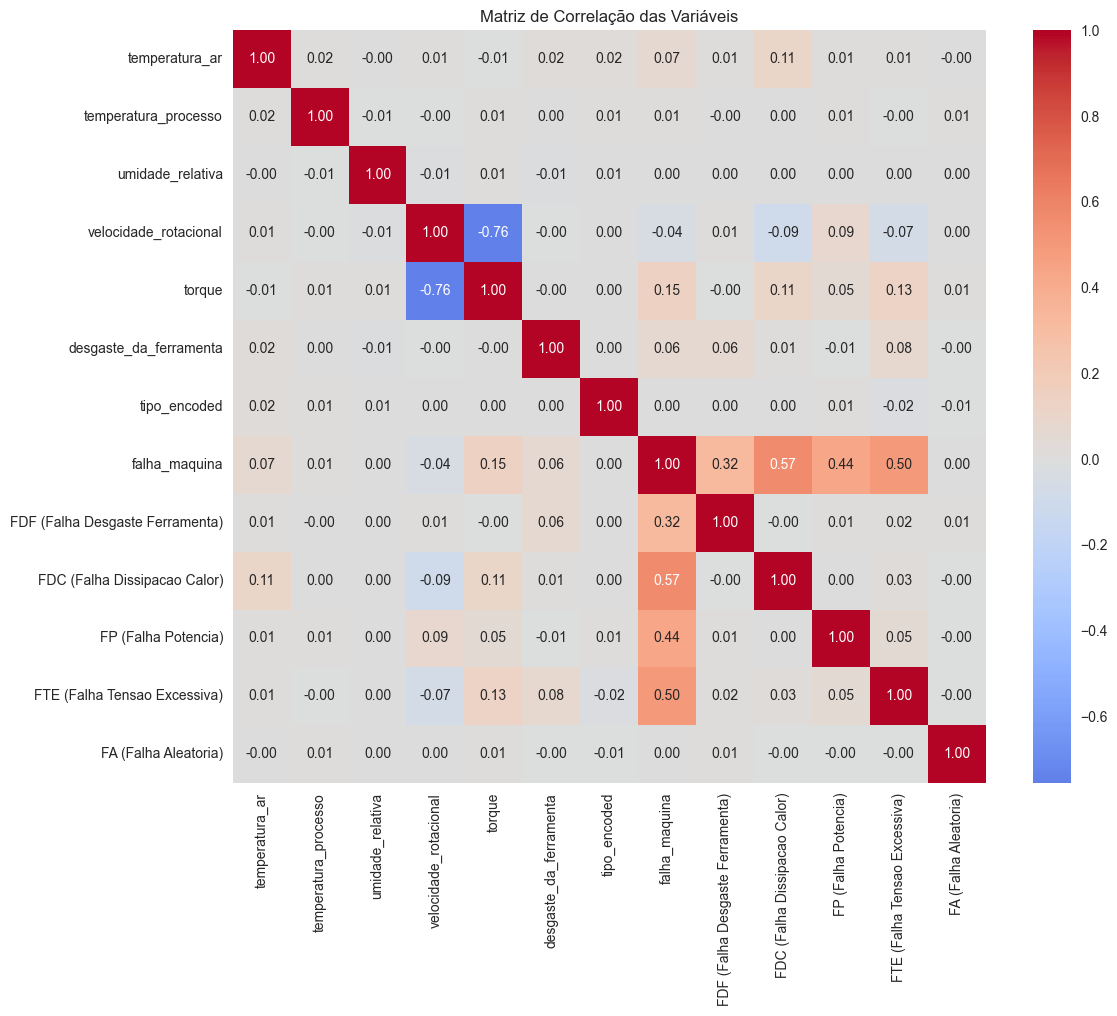

In [69]:
# Matriz de correlação
# Preparar dados para correlação
correlation_data = df_clean.copy()

# Codificar variável categórica 'tipo'
le_tipo = LabelEncoder()
correlation_data['tipo_encoded'] = le_tipo.fit_transform(correlation_data['tipo'])

# Selecionar apenas colunas numéricas para correlação
numeric_cols_for_corr = numeric_columns + ['tipo_encoded', 'falha_maquina'] + failure_cols
numeric_cols_for_corr = [col for col in numeric_cols_for_corr if col in correlation_data.columns]

correlation_matrix = correlation_data[numeric_cols_for_corr].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, fmt='.2f')
plt.title('Matriz de Correlação das Variáveis')
plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>

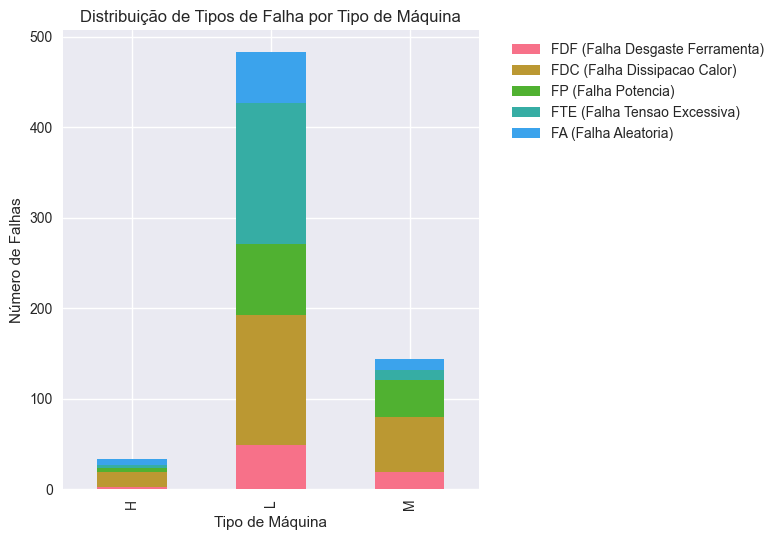

Tabela de falhas por tipo de máquina:
      FDF (Falha Desgaste Ferramenta)  FDC (Falha Dissipacao Calor)  \
tipo                                                                  
H                                 3.0                          16.0   
L                                49.0                         144.0   
M                                19.0                          61.0   

      FP (Falha Potencia)  FTE (Falha Tensao Excessiva)  FA (Falha Aleatoria)  
tipo                                                                           
H                     5.0                             3                   6.0  
L                    78.0                           156                  56.0  
M                    41.0                            11                  12.0  


In [70]:
# Análise de falhas por tipo de máquina
failure_by_type = df_clean.groupby('tipo')[failure_cols].sum()

plt.figure(figsize=(12, 6))
failure_by_type.plot(kind='bar', stacked=True)
plt.title('Distribuição de Tipos de Falha por Tipo de Máquina')
plt.xlabel('Tipo de Máquina')
plt.ylabel('Número de Falhas')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

print("Tabela de falhas por tipo de máquina:")
print(failure_by_type)

## 5. Feature Engineering e Preparação dos Dados

In [71]:
# Criar features derivadas
df_features = df_clean.copy()

# 1. Diferença entre temperaturas
df_features['temp_diff'] = df_features['temperatura_processo'] - df_features['temperatura_ar']

# 2. Potência estimada (torque * velocidade)
df_features['potencia_estimada'] = df_features['torque'] * df_features['velocidade_rotacional']

# 3. Eficiência térmica
df_features['eficiencia_termica'] = df_features['temperatura_processo'] / df_features['temperatura_ar']

# 4. Indicador de desgaste alto
desgaste_threshold = df_features['desgaste_da_ferramenta'].quantile(0.75)
df_features['desgaste_alto'] = (df_features['desgaste_da_ferramenta'] > desgaste_threshold).astype(int)

# 5. Combinação de stress operacional
# Normalizar variáveis para criar índice de stress
from sklearn.preprocessing import MinMaxScaler
scaler_stress = MinMaxScaler()
stress_vars = ['temperatura_processo', 'velocidade_rotacional', 'torque', 'desgaste_da_ferramenta']
stress_normalized = scaler_stress.fit_transform(df_features[stress_vars])
df_features['stress_operacional'] = np.mean(stress_normalized, axis=1)

print("Features criadas:")
new_features = ['temp_diff', 'potencia_estimada', 'eficiencia_termica', 'desgaste_alto', 'stress_operacional']
print(df_features[new_features].describe())

Features criadas:
          temp_diff  potencia_estimada  eficiencia_termica  desgaste_alto  \
count  35260.000000       35260.000000        35260.000000   35260.000000   
mean     -18.958437       60263.198992            0.936787       0.246540   
std       96.176223       10032.454177            0.320724       0.431003   
min     -342.300000        7485.000000           -0.128552       0.000000   
25%        9.100000       53920.000000            1.030080       0.000000   
50%        9.800000       60195.200000            1.032580       0.000000   
75%       10.900000       66676.425000            1.036651       0.000000   
max       13.800000      152856.200000            1.046081       1.000000   

       stress_operacional  
count        35260.000000  
mean             0.505561  
std              0.092611  
min              0.091741  
25%              0.460438  
50%              0.520505  
75%              0.568153  
max              0.811311  


In [72]:
# Preparar variáveis target e features
# Definir o problema como classificação multilabel

# Features
feature_columns = numeric_columns + new_features
X = df_features[feature_columns]

# Codificar tipo de máquina
le_tipo = LabelEncoder()
X['tipo_encoded'] = le_tipo.fit_transform(df_features['tipo'])

# Targets (abordagem multilabel)
target_columns = [col for col in failure_columns if col in df_features.columns]
y_multilabel = df_features[target_columns]

# Target binário (qualquer falha)
y_binary = df_features['falha_maquina']

print(f"Shape das features: {X.shape}")
print(f"Shape dos targets multilabel: {y_multilabel.shape}")
print(f"Shape do target binário: {y_binary.shape}")

# Verificar balanceamento das classes
print("\n=== BALANCEAMENTO DAS CLASSES ===")
print("Target binário (falha geral):")
print(y_binary.value_counts(normalize=True))

print("\nTargets específicos:")
for col in target_columns:
    print(f"{col}: {y_multilabel[col].value_counts(normalize=True).to_dict()}")

Shape das features: (35260, 12)
Shape dos targets multilabel: (35260, 5)
Shape do target binário: (35260,)

=== BALANCEAMENTO DAS CLASSES ===
Target binário (falha geral):
falha_maquina
0.0    0.981567
1.0    0.018433
Name: proportion, dtype: float64

Targets específicos:
FDF (Falha Desgaste Ferramenta): {0.0: 0.9979823813583404, 1.0: 0.0020176186416595624}
FDC (Falha Dissipacao Calor): {0.0: 0.9937315634218289, 1.0: 0.006268436578171091}
FP (Falha Potencia): {0.0: 0.996483067672585, 1.0: 0.0035169323274150547}
FTE (Falha Tensao Excessiva): {0: 0.9951786727169597, 1: 0.004821327283040272}
FA (Falha Aleatoria): {0.0: 0.9978971298664393, 1.0: 0.0021028701335606705}


## 6. Divisão dos Dados e Preprocessamento

In [73]:
# Remover linhas com valores ausentes nos targets antes de dividir os dados
print("=== TRATAMENTO DE VALORES AUSENTES NOS TARGETS ===")
print(f"Shape antes da limpeza: {X.shape}")
print(f"Valores ausentes em y_binary: {y_binary.isna().sum()}")
print(f"Valores ausentes em y_multilabel:")
print(y_multilabel.isna().sum())

# Encontrar índices válidos (sem NaN nos targets)
valid_idx = ~(y_binary.isna() | y_multilabel.isna().any(axis=1))
X_clean = X[valid_idx].copy()
y_binary_clean = y_binary[valid_idx].copy()
y_multilabel_clean = y_multilabel[valid_idx].copy()

print(f"Shape após limpeza: {X_clean.shape}")
print(f"Linhas removidas: {(~valid_idx).sum()}")

# Dividir os dados
X_train, X_test, y_binary_train, y_binary_test = train_test_split(
    X_clean, y_binary_clean, test_size=0.2, random_state=42, stratify=y_binary_clean
)

X_train_ml, X_test_ml, y_multilabel_train, y_multilabel_test = train_test_split(
    X_clean, y_multilabel_clean, test_size=0.2, random_state=42
)

print(f"Dados de treino - X: {X_train.shape}, y_binary: {y_binary_train.shape}")
print(f"Dados de teste - X: {X_test.shape}, y_binary: {y_binary_test.shape}")
print(f"Dados multilabel - treino: {y_multilabel_train.shape}, teste: {y_multilabel_test.shape}")

# Escalonamento das features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_ml_scaled = scaler.fit_transform(X_train_ml)
X_test_ml_scaled = scaler.transform(X_test_ml)

print("\nEscalonamento concluído.")

=== TRATAMENTO DE VALORES AUSENTES NOS TARGETS ===
Shape antes da limpeza: (35260, 12)
Valores ausentes em y_binary: 703
Valores ausentes em y_multilabel:
FDF (Falha Desgaste Ferramenta)    70
FDC (Falha Dissipacao Calor)        4
FP (Falha Potencia)                 2
FTE (Falha Tensao Excessiva)        0
FA (Falha Aleatoria)               70
dtype: int64
Shape após limpeza: (34413, 12)
Linhas removidas: 847
Dados de treino - X: (27530, 12), y_binary: (27530,)
Dados de teste - X: (6883, 12), y_binary: (6883,)
Dados multilabel - treino: (27530, 5), teste: (6883, 5)

Escalonamento concluído.


## 7. Treinamento de Modelos

In [74]:
# Modelo 1: Classificação Binária (Falha Geral)
print("=== TREINAMENTO - CLASSIFICAÇÃO BINÁRIA ===")

models_binary = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': xgb.XGBClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000)
}

results_binary = {}

for name, model in models_binary.items():
    # Cross-validation
    cv_scores = cross_val_score(model, X_train_scaled, y_binary_train, cv=5, scoring='roc_auc')
    
    # Treinar modelo completo
    model.fit(X_train_scaled, y_binary_train)
    
    # Predições
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    
    # Métricas
    auc_score = roc_auc_score(y_binary_test, y_pred_proba)
    
    results_binary[name] = {
        'model': model,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'auc_test': auc_score,
        'predictions': y_pred,
        'probabilities': y_pred_proba
    }
    
    print(f"{name}:")
    print(f"  CV AUC: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
    print(f"  Test AUC: {auc_score:.4f}")
    print()

=== TREINAMENTO - CLASSIFICAÇÃO BINÁRIA ===
Random Forest:
  CV AUC: 0.9078 (+/- 0.0303)
  Test AUC: 0.8897

Gradient Boosting:
  CV AUC: 0.9217 (+/- 0.0406)
  Test AUC: 0.9236

XGBoost:
  CV AUC: 0.9230 (+/- 0.0204)
  Test AUC: 0.9133

Logistic Regression:
  CV AUC: 0.8666 (+/- 0.0434)
  Test AUC: 0.8610



In [75]:
# Modelo 2: Classificação Multilabel (Tipos Específicos de Falha)
print("=== TREINAMENTO - CLASSIFICAÇÃO MULTILABEL ===")

base_models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBoost': xgb.XGBClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000)
}

models_multilabel = {}
results_multilabel = {}

for name, base_model in base_models.items():
    # Usar MultiOutputClassifier para problemas multilabel
    multilabel_model = MultiOutputClassifier(base_model)
    
    # Treinar
    multilabel_model.fit(X_train_ml_scaled, y_multilabel_train)
    
    # Predições
    y_pred_ml = multilabel_model.predict(X_test_ml_scaled)
    
    models_multilabel[name] = multilabel_model
    results_multilabel[name] = y_pred_ml
    
    print(f"Modelo {name} treinado para classificação multilabel.")

print("\nTreinamento multilabel concluído.")

=== TREINAMENTO - CLASSIFICAÇÃO MULTILABEL ===
Modelo Random Forest treinado para classificação multilabel.
Modelo XGBoost treinado para classificação multilabel.
Modelo Logistic Regression treinado para classificação multilabel.

Treinamento multilabel concluído.


## 8. Avaliação dos Modelos

=== MELHOR MODELO BINÁRIO: Gradient Boosting ===
AUC Test: 0.9236

Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      6758
         1.0       0.57      0.42      0.49       125

    accuracy                           0.98      6883
   macro avg       0.78      0.71      0.74      6883
weighted avg       0.98      0.98      0.98      6883



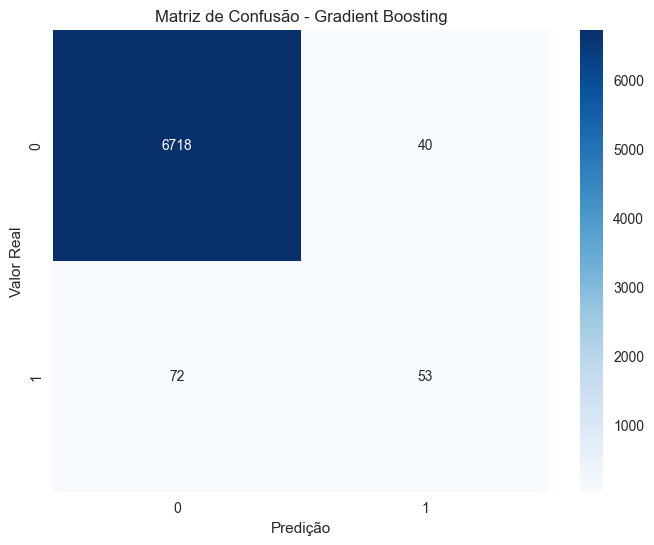

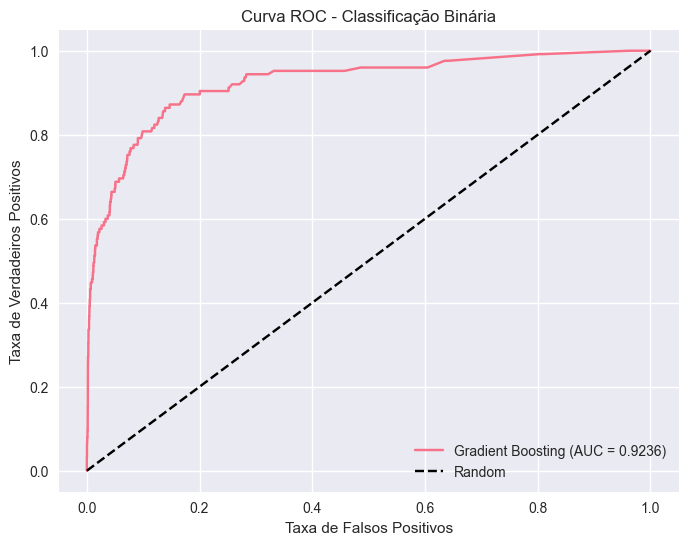

In [76]:
# Avaliação detalhada do melhor modelo binário
best_binary_model = max(results_binary.items(), key=lambda x: x[1]['auc_test'])
best_name, best_result = best_binary_model

print(f"=== MELHOR MODELO BINÁRIO: {best_name} ===")
print(f"AUC Test: {best_result['auc_test']:.4f}")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_binary_test, best_result['predictions']))

# Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_binary_test, best_result['predictions'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Matriz de Confusão - {best_name}')
plt.ylabel('Valor Real')
plt.xlabel('Predição')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_binary_test, best_result['probabilities'])
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'{best_name} (AUC = {best_result["auc_test"]:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC - Classificação Binária')
plt.legend()
plt.show()

In [77]:
# Avaliação dos modelos multilabel
print("=== AVALIAÇÃO MODELOS MULTILABEL ===")

from sklearn.metrics import hamming_loss, jaccard_score

for name, predictions in results_multilabel.items():
    # Hamming Loss (menor é melhor)
    hamming = hamming_loss(y_multilabel_test, predictions)
    
    # Jaccard Score (maior é melhor)
    jaccard = jaccard_score(y_multilabel_test, predictions, average='macro')
    
    print(f"\n{name}:")
    print(f"  Hamming Loss: {hamming:.4f}")
    print(f"  Jaccard Score: {jaccard:.4f}")
    
    # Classification report para cada classe
    print(f"\n  Classification Report por classe:")
    for i, col in enumerate(target_columns):
        print(f"\n  {col}:")
        print(classification_report(y_multilabel_test.iloc[:, i], predictions[:, i]))

=== AVALIAÇÃO MODELOS MULTILABEL ===

Random Forest:
  Hamming Loss: 0.0031
  Jaccard Score: 0.1730

  Classification Report por classe:

  FDF (Falha Desgaste Ferramenta):
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      6873
         1.0       0.00      0.00      0.00        10

    accuracy                           1.00      6883
   macro avg       0.50      0.50      0.50      6883
weighted avg       1.00      1.00      1.00      6883


  FDC (Falha Dissipacao Calor):
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      6839
         1.0       0.71      0.50      0.59        44

    accuracy                           1.00      6883
   macro avg       0.85      0.75      0.79      6883
weighted avg       0.99      1.00      1.00      6883


  FP (Falha Potencia):
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      6853
       

## 9. Importância das Features

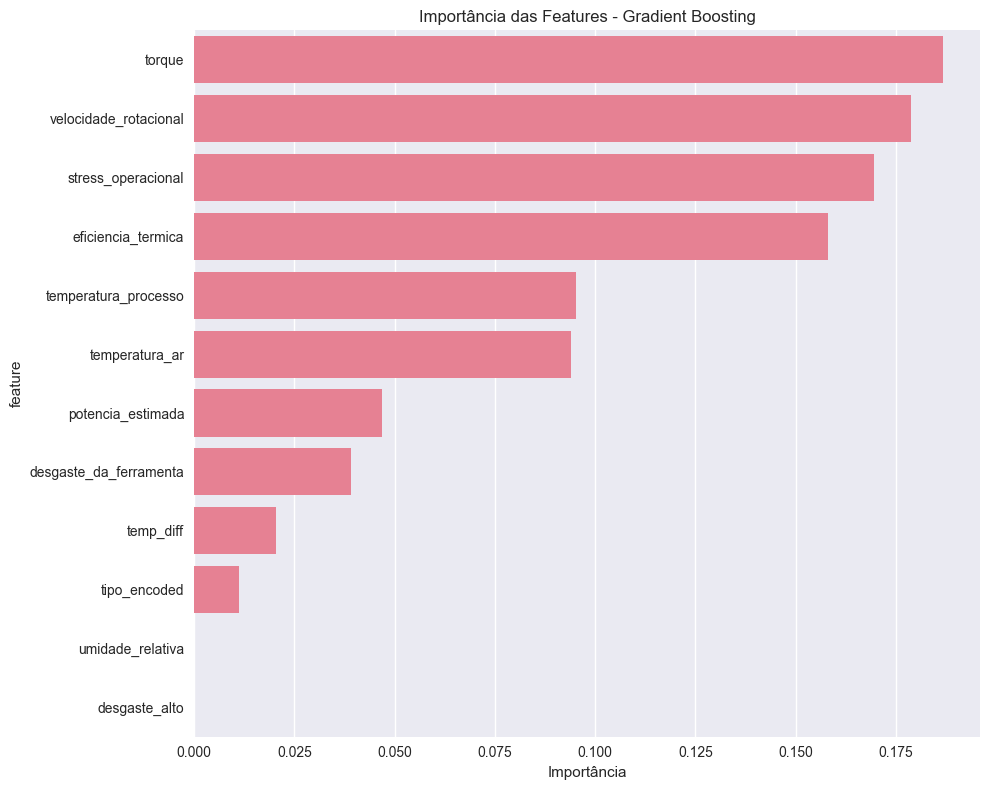

Top 10 features mais importantes:
                   feature  importance
4                   torque    0.186668
3    velocidade_rotacional    0.178685
10      stress_operacional    0.169616
8       eficiencia_termica    0.158084
1     temperatura_processo    0.095264
0           temperatura_ar    0.093903
7        potencia_estimada    0.046889
5   desgaste_da_ferramenta    0.039091
6                temp_diff    0.020468
11            tipo_encoded    0.011332


In [78]:
# Importância das features do melhor modelo
if hasattr(best_result['model'], 'feature_importances_'):
    feature_names = list(X.columns)
    importances = best_result['model'].feature_importances_
    
    # Criar DataFrame para visualização
    feature_importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    }).sort_values('importance', ascending=False)
    
    # Plot
    plt.figure(figsize=(10, 8))
    sns.barplot(data=feature_importance_df.head(15), x='importance', y='feature')
    plt.title(f'Importância das Features - {best_name}')
    plt.xlabel('Importância')
    plt.tight_layout()
    plt.show()
    
    print("Top 10 features mais importantes:")
    print(feature_importance_df.head(10))
else:
    print(f"Modelo {best_name} não possui feature_importances_.")

## 10. Predições no Dataset de Teste

In [79]:
# Preparar dataset de teste para predição
df_test_clean = df_test.copy()

# Aplicar mesmo preprocessamento
# 1. Tratar valores numéricos
for col in numeric_columns:
    if col in df_test_clean.columns:
        df_test_clean[col] = pd.to_numeric(df_test_clean[col], errors='coerce')

# 2. Imputar valores ausentes usando estatísticas do treino
for col in numeric_columns:
    if col in df_test_clean.columns and df_test_clean[col].isnull().sum() > 0:
        median_value = df_features[col].median()
        df_test_clean[col].fillna(median_value, inplace=True)

# 3. Criar features derivadas
df_test_clean['temp_diff'] = df_test_clean['temperatura_processo'] - df_test_clean['temperatura_ar']
df_test_clean['potencia_estimada'] = df_test_clean['torque'] * df_test_clean['velocidade_rotacional']
df_test_clean['eficiencia_termica'] = df_test_clean['temperatura_processo'] / df_test_clean['temperatura_ar']
df_test_clean['desgaste_alto'] = (df_test_clean['desgaste_da_ferramenta'] > desgaste_threshold).astype(int)

# Stress operacional
stress_test_normalized = scaler_stress.transform(df_test_clean[stress_vars])
df_test_clean['stress_operacional'] = np.mean(stress_test_normalized, axis=1)

# 4. Preparar features
X_test_pred = df_test_clean[feature_columns]
X_test_pred['tipo_encoded'] = le_tipo.transform(df_test_clean['tipo'])

# 5. Escalonar
X_test_pred_scaled = scaler.transform(X_test_pred)

print(f"Dataset de teste preparado: {X_test_pred_scaled.shape}")

Dataset de teste preparado: (7173, 12)


In [80]:
# Fazer predições
# Predição binária (falha geral)
pred_binary = best_result['model'].predict(X_test_pred_scaled)
pred_binary_proba = best_result['model'].predict_proba(X_test_pred_scaled)[:, 1]

# Predição multilabel (tipos específicos)
best_multilabel_name = 'Random Forest'  # Escolher o melhor baseado na avaliação
pred_multilabel = models_multilabel[best_multilabel_name].predict(X_test_pred_scaled)

# Criar DataFrame de resultados
results_df = df_test.copy()
results_df['falha_predita'] = pred_binary
results_df['probabilidade_falha'] = pred_binary_proba

# Adicionar predições multilabel
for i, col in enumerate(target_columns):
    results_df[f'{col}_predito'] = pred_multilabel[:, i]

print("Predições concluídas!")
print(f"\nResumo das predições:")
print(f"Total de amostras: {len(results_df)}")
print(f"Falhas previstas: {pred_binary.sum()} ({pred_binary.mean():.2%})")
print(f"Probabilidade média de falha: {pred_binary_proba.mean():.4f}")

# Mostrar primeiras predições
print("\nPrimeiras 10 predições:")
display_cols = ['id', 'tipo', 'falha_predita', 'probabilidade_falha'] + [f'{col}_predito' for col in target_columns]
print(results_df[display_cols].head(10))

Predições concluídas!

Resumo das predições:
Total de amostras: 7173
Falhas previstas: 168.0 (2.34%)
Probabilidade média de falha: 0.0281

Primeiras 10 predições:
      id tipo  falha_predita  probabilidade_falha  \
0  35260    L            0.0             0.005265   
1  35261    M            0.0             0.009526   
2  35262    M            0.0             0.002691   
3  35263    L            0.0             0.007020   
4  35264    L            0.0             0.007020   
5  35265    H            0.0             0.033767   
6  35266    H            0.0             0.009804   
7  35267    L            0.0             0.049071   
8  35268    M            0.0             0.002756   
9  35269    M            0.0             0.002691   

   FDF (Falha Desgaste Ferramenta)_predito  \
0                                      0.0   
1                                      0.0   
2                                      0.0   
3                                      0.0   
4                      

## 11. Insights e Recomendações de Negócio

In [81]:
# Análise de insights de negócio
print("=== INSIGHTS E RECOMENDAÇÕES DE NEGÓCIO ===")

# 1. Análise por tipo de máquina
failure_rate_by_type = results_df.groupby('tipo').agg({
    'falha_predita': ['count', 'sum', 'mean'],
    'probabilidade_falha': 'mean'
}).round(4)

print("\n1. TAXA DE FALHA POR TIPO DE MÁQUINA:")
print(failure_rate_by_type)

# 2. Distribuição de tipos de falha previstos
failure_types_pred = {}
for col in target_columns:
    pred_col = f'{col}_predito'
    if pred_col in results_df.columns:
        failure_types_pred[col] = results_df[pred_col].sum()

print("\n2. DISTRIBUIÇÃO DE TIPOS DE FALHA PREVISTOS:")
for failure_type, count in failure_types_pred.items():
    percentage = count / len(results_df) * 100
    print(f"{failure_type}: {count} casos ({percentage:.2f}%)")

# 3. Máquinas de alto risco
high_risk_threshold = 0.7
high_risk_machines = results_df[results_df['probabilidade_falha'] > high_risk_threshold]

print(f"\n3. MÁQUINAS DE ALTO RISCO (probabilidade > {high_risk_threshold}):")
print(f"Total: {len(high_risk_machines)} máquinas")
if len(high_risk_machines) > 0:
    print("\nTop 10 máquinas com maior risco:")
    top_risk = high_risk_machines.nlargest(10, 'probabilidade_falha')
    print(top_risk[['id', 'id_produto', 'tipo', 'probabilidade_falha']].to_string(index=False))

# 4. Recomendações operacionais
print("\n=== RECOMENDAÇÕES OPERACIONAIS ===")

print("\n1. MANUTENÇÃO PREVENTIVA:")
print(f"   - Priorizar {len(high_risk_machines)} máquinas com probabilidade de falha > {high_risk_threshold}")
print(f"   - Implementar inspeções frequentes em máquinas tipo {failure_rate_by_type.idxmax()[('falha_predita', 'mean')]}")

print("\n2. MONITORAMENTO ESPECÍFICO:")
most_common_failure = max(failure_types_pred, key=failure_types_pred.get)
print(f"   - Foco especial em {most_common_failure}")
print(f"   - Monitoramento contínuo de temperaturas e torque")

print("\n3. GESTÃO DE ESTOQUE:")
print(f"   - Manter peças de reposição para {most_common_failure}")
print(f"   - Planejamento de manutenção para próximos 30 dias baseado nas predições")

=== INSIGHTS E RECOMENDAÇÕES DE NEGÓCIO ===

1. TAXA DE FALHA POR TIPO DE MÁQUINA:
     falha_predita                probabilidade_falha
             count    sum    mean                mean
tipo                                                 
H              528    5.0  0.0095              0.0189
L             4846  130.0  0.0268              0.0313
M             1799   33.0  0.0183              0.0224

2. DISTRIBUIÇÃO DE TIPOS DE FALHA PREVISTOS:
FDF (Falha Desgaste Ferramenta): 0.0 casos (0.00%)
FDC (Falha Dissipacao Calor): 79.0 casos (1.10%)
FP (Falha Potencia): 29.0 casos (0.40%)
FTE (Falha Tensao Excessiva): 18.0 casos (0.25%)
FA (Falha Aleatoria): 2.0 casos (0.03%)

3. MÁQUINAS DE ALTO RISCO (probabilidade > 0.7):
Total: 109 máquinas

Top 10 máquinas com maior risco:
   id id_produto tipo  probabilidade_falha
38221     M18727    M             0.999869
36794     L51434    L             0.997517
39234     L51962    L             0.997203
40487     L52066    L             0.991707

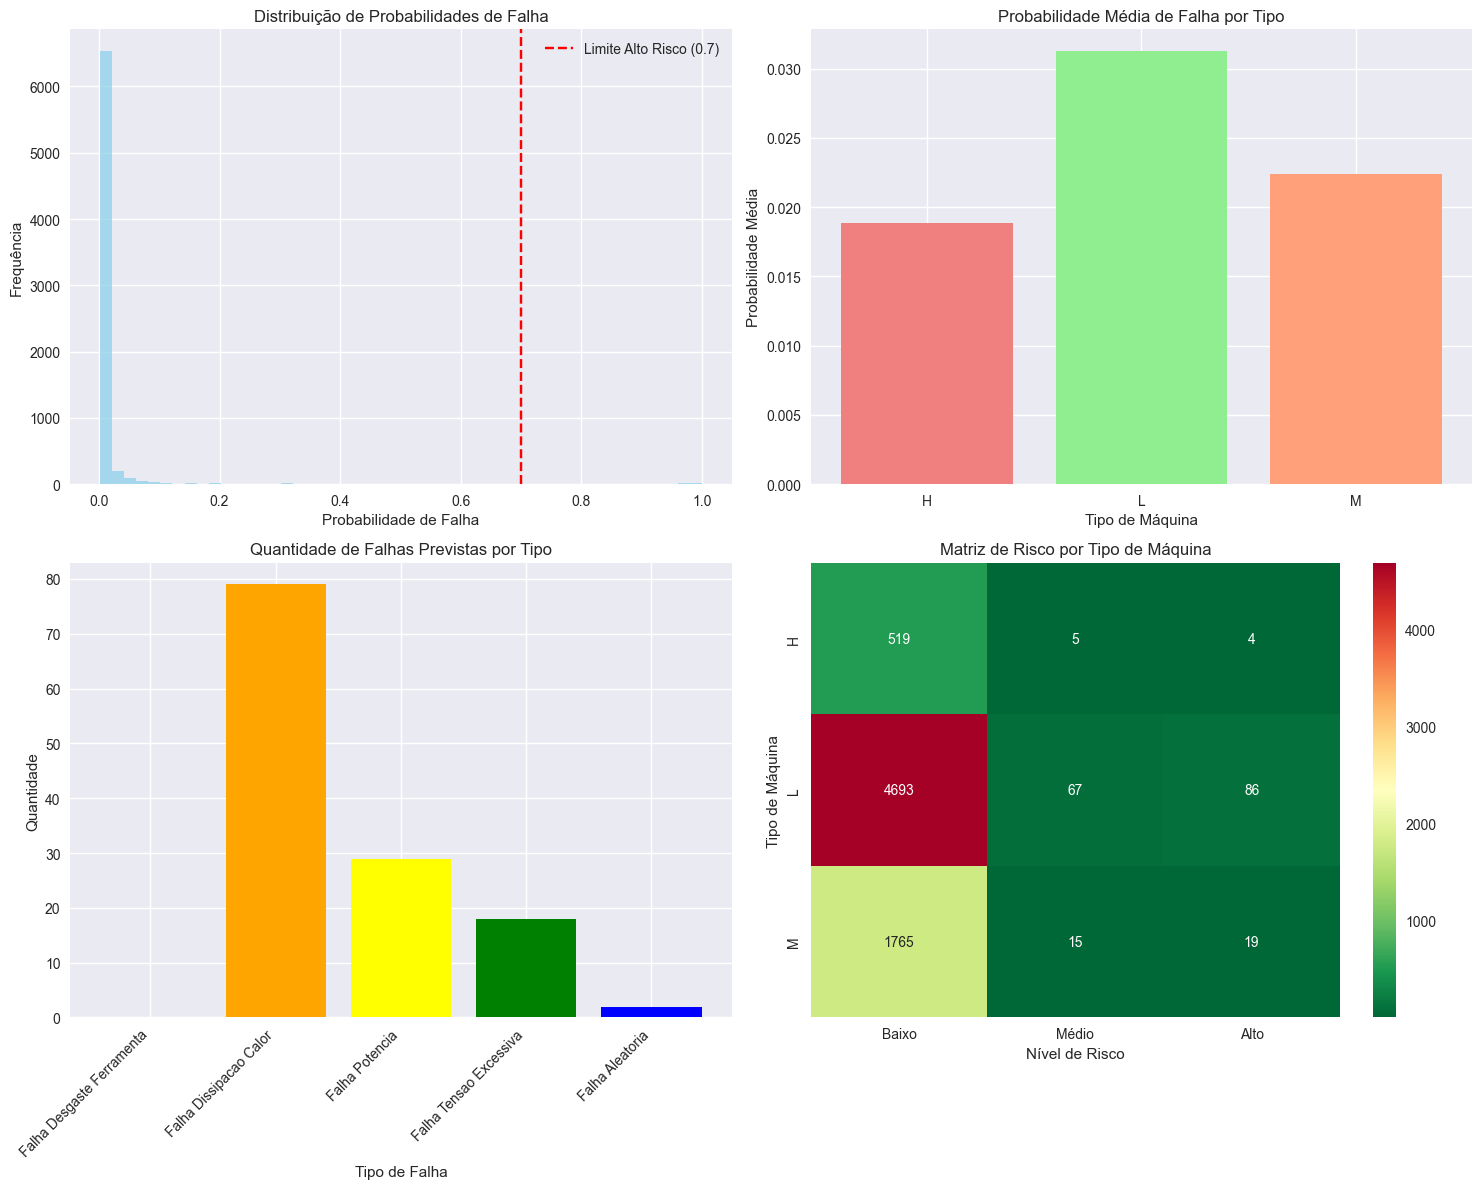

In [82]:
# Visualização final - Dashboard de monitoramento
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Distribuição de probabilidades de falha
axes[0, 0].hist(results_df['probabilidade_falha'], bins=50, alpha=0.7, color='skyblue')
axes[0, 0].axvline(high_risk_threshold, color='red', linestyle='--', label=f'Limite Alto Risco ({high_risk_threshold})')
axes[0, 0].set_title('Distribuição de Probabilidades de Falha')
axes[0, 0].set_xlabel('Probabilidade de Falha')
axes[0, 0].set_ylabel('Frequência')
axes[0, 0].legend()

# 2. Falhas por tipo de máquina
type_failure_rate = results_df.groupby('tipo')['probabilidade_falha'].mean()
axes[0, 1].bar(type_failure_rate.index, type_failure_rate.values, color=['lightcoral', 'lightgreen', 'lightsalmon'])
axes[0, 1].set_title('Probabilidade Média de Falha por Tipo')
axes[0, 1].set_xlabel('Tipo de Máquina')
axes[0, 1].set_ylabel('Probabilidade Média')

# 3. Tipos de falha previstos
failure_names = [col.split('(')[1].split(')')[0] if '(' in col else col for col in failure_types_pred.keys()]
axes[1, 0].bar(range(len(failure_types_pred)), list(failure_types_pred.values()), 
               color=['red', 'orange', 'yellow', 'green', 'blue'])
axes[1, 0].set_title('Quantidade de Falhas Previstas por Tipo')
axes[1, 0].set_xlabel('Tipo de Falha')
axes[1, 0].set_ylabel('Quantidade')
axes[1, 0].set_xticks(range(len(failure_types_pred)))
axes[1, 0].set_xticklabels(failure_names, rotation=45, ha='right')

# 4. Matriz de risco
risk_matrix = pd.crosstab(results_df['tipo'], 
                         pd.cut(results_df['probabilidade_falha'], 
                               bins=[0, 0.3, 0.7, 1.0], 
                               labels=['Baixo', 'Médio', 'Alto']))
sns.heatmap(risk_matrix, annot=True, fmt='d', cmap='RdYlGn_r', ax=axes[1, 1])
axes[1, 1].set_title('Matriz de Risco por Tipo de Máquina')
axes[1, 1].set_xlabel('Nível de Risco')
axes[1, 1].set_ylabel('Tipo de Máquina')

plt.tight_layout()
plt.show()

In [83]:
# Salvar resultados
results_df.to_csv('predicoes_manutencao_preditiva.csv', index=False)
print("Resultados salvos em 'predicoes_manutencao_preditiva.csv'")

# Salvar modelo
import joblib
joblib.dump(best_result['model'], 'modelo_manutencao_preditiva.pkl')
joblib.dump(scaler, 'scaler_features.pkl')
print("Modelo e scaler salvos.")

print("\n=== PROJETO CONCLUÍDO ===")
print(f"Melhor modelo: {best_name}")
print(f"AUC Score: {best_result['auc_test']:.4f}")
print(f"Total de predições: {len(results_df)}")
print(f"Máquinas de alto risco identificadas: {len(high_risk_machines)}")

Resultados salvos em 'predicoes_manutencao_preditiva.csv'
Modelo e scaler salvos.

=== PROJETO CONCLUÍDO ===
Melhor modelo: Gradient Boosting
AUC Score: 0.9236
Total de predições: 7173
Máquinas de alto risco identificadas: 109
